In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pyranges as pr
from tqdm import tqdm
import seaborn as sns

In [2]:
# GAF motifs from ChIP-seq
ALL_motifs = pd.read_csv('./GAGAG_dm3.csv')
ChIP_seq = pd.read_csv('./Fuda_ChIP_peaks.csv')
# nucleosome positions
nucleosomes = pr.read_bed('./dmNuc0210501.nucleosome.iNPSPeak.bed')

# GAGA ChIP-seq from Fuda

In [3]:
ChIP_seq_hc = ChIP_seq[ChIP_seq['Jaspar_hcGAF']=='yes']

In [4]:
def count_motifs(sequence):
    count = 0
    ones = 0  # Counter for consecutive 1s

    for num in sequence:
        if num == 1:
            ones += 1
            if ones == 5:  # Found 5 consecutive 1s
                count += 1
                ones = 0
        else:
            # Reset the counter if the sequence is broken
            ones = 0

    return count

In [5]:
def obtainMotifNumbers(data, motifs):
    peakName = []
    peakIntensity = []
    peakNumMotif = []
    for chrom in data['chromosome'].unique():
        chrom_motifs = motifs[motifs['chr']==chrom]
        chrom_ChIP = data[data['chromosome']==chrom]
        chromMap = np.zeros(chrom_ChIP['end'].max())
        for start in chrom_motifs['start']:
            chromMap[start:start+5] = 1
        for index, peakInfo in chrom_ChIP.iterrows():
            peakName.append(peakInfo['peakName'])
            peakIntensity.append(peakInfo['untreated_GAF_intensity'])
            peakNumMotif.append(count_motifs(chromMap[peakInfo['start']:peakInfo['end']+1]))
    peakIntensity = np.array(peakIntensity)
    peakNumMotif = np.array(peakNumMotif)
    return peakName, peakIntensity, peakNumMotif

peakName, peakIntensity, peakNumMotif = obtainMotifNumbers(ChIP_seq_hc, ALL_motifs)

In [6]:
intensity_of_cluster_raw = pd.DataFrame({
    'peak':peakName, 'intensity':peakIntensity, 'numMotif':peakNumMotif, 'normed':'no'
})
intensity_of_cluster_normed = pd.DataFrame({
    'peak':peakName, 'intensity':peakIntensity/peakNumMotif, 'numMotif':peakNumMotif, 'normed':'yes'
})

/var/folders/d3/vhnxc7ys74jcv_vrsv5c0d7c0000gn/T/ipykernel_22388/2496498066.py:5: RuntimeWarning: divide by zero encountered in divide
  'peak':peakName, 'intensity':peakIntensity/peakNumMotif, 'numMotif':peakNumMotif, 'normed':'yes'


In [7]:
def calculate_mad_groupby(df, Nbootstraps=10, groupby_column='numMotif', value_column='intensity'):
    """
    Calculate the Median Absolute Deviation (MAD) for grouped data in a pandas DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - groupby_column (str): The column to group by.
    - value_column (str): The column containing values to calculate MAD for.
    
    Returns:
    - pd.DataFrame: A DataFrame with groups and their corresponding MAD values.
    """
    def mad(series):
        bootStrap = []
        for i in range(Nbootstraps):
            bootstrap_sample = series.sample(frac=1, replace=True)
            bootStrap.append(bootstrap_sample.median())
        return np.std(bootStrap)
    
    # Apply MAD calculation to each group
    result = df.groupby(groupby_column)[value_column].apply(mad).reset_index()
    result.columns = [groupby_column, 'MAD']  # Rename the columns
    return result['MAD']


In [ ]:
data = intensity_of_cluster_raw
for n in range(1,11):
    print(n, np.sum(data['numMotif']==n))

1 505
2 646
3 637
4 552
5 437
6 303
7 193
8 126
9 84
10 34


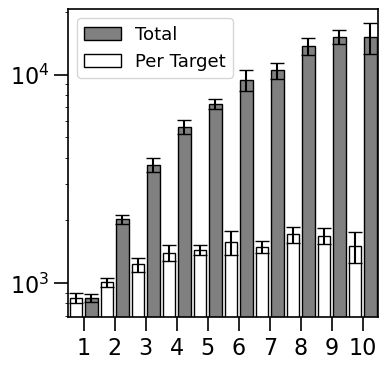

In [8]:
plt.figure(figsize=(4,4))
plt.tick_params(length=10, width=1.2)
ax = plt.subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.2)

N_bootstrap = 100

data = intensity_of_cluster_raw
data = data[(data['numMotif']<=10) & (data['numMotif']>0)]
dataNumMotif = np.sort(data['numMotif'].unique())
NDATA = data.groupby('numMotif')['intensity'].size()
plt.bar(
    2*dataNumMotif, 
    data.groupby('numMotif')['intensity'].median(), 
    yerr=calculate_mad_groupby(data, N_bootstrap),
    capsize=5, edgecolor='black', facecolor='gray', label='Total'
)

data = intensity_of_cluster_normed
data = data[(data['numMotif']<=10) & (data['numMotif']>0)]
dataNumMotif = np.sort(data['numMotif'].unique())
NDATA = data.groupby('numMotif')['intensity'].size()
plt.bar(
    2*dataNumMotif-1, 
    data.groupby('numMotif')['intensity'].median(), 
    yerr=calculate_mad_groupby(data, N_bootstrap),
    capsize=5, edgecolor='black', facecolor='none', label='Per Target'
)

plt.xlim([0.5, 20.5])
plt.semilogy()
# plt.ylim([0,2500])

plt.legend(loc='upper left', fontsize=13)

plt.xticks(2*dataNumMotif-0.5, dataNumMotif, fontsize=16)
plt.yticks(fontsize=16)

plt.show()

# GAGAG motif distances

In [9]:
from collections import Counter

def find_motifs_between_dyads(chrom, motif):
    """
    Identify the distribution of the number of complete motifs between nucleosome dyads.
    
    Parameters:
    chrom (list or np.array): {0, 1} sequence where 0 represents free DNA and 1 represents dyad of nucleosome.
    motif (pd.DataFrame): DataFrame with "start" and "end" columns indicating motif positions.

    Returns:
    dict: Distribution of the number of motifs between dyads.
    """
    
    # Find indices of dyads
    dyad_indices = []
    for i, row in chrom.df.iterrows():
        if row.Name.split(':')[1].strip() == 'MainPeak':
            midleft = int(np.floor((row['Start'] + row['End'])/2))
            dyad_indices.append(midleft)

    # Ensure dyad_indices is sorted
    dyad_indices.sort()
    
    # Count complete motifs between consecutive dyads
    motif_counts = []
    for i in range(len(dyad_indices) - 1):
        start_dyad = dyad_indices[i]
        end_dyad = dyad_indices[i + 1]
        
        # Count motifs completely between the current dyads
        count = sum((motif["start"] > start_dyad) & (motif["end"] < end_dyad))
        motif_counts.append(count)

    # Calculate the distribution of motif counts
    distribution = dict(Counter(motif_counts))
    
    return distribution

# Example usage
distributions_all = []
for chrom in ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX', 'chrY']:
    print(chrom, end='... ')
    distributions_all.append(find_motifs_between_dyads(
        nucleosomes[chrom], ALL_motifs[ALL_motifs['chr']==chrom]
    ))
print('end.')
# print(distribution)


chr2L... chr2R... chr3L... chr3R... chr4... chrX... chrY... end.


In [10]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

In [11]:
distribution_all_combined = {}
for distribution in distributions_all:
    for count in distribution.keys():
        if count > 0:
            if count in distribution_all_combined:
                distribution_all_combined[count] += distribution[count]
            else:
                distribution_all_combined[count] = distribution[count]

threshold = 7
for count in list(distribution_all_combined.keys()):
    if count > threshold:
        distribution_all_combined[threshold] += distribution_all_combined.pop(count)

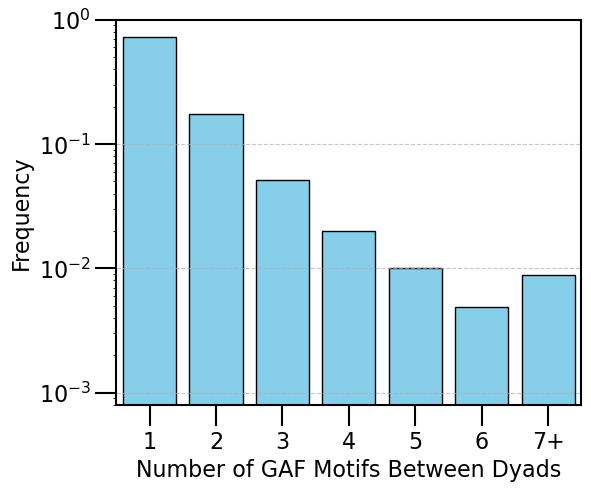

In [12]:
counts = np.array(list(distribution_all_combined.keys()))
frequencies = np.array(list(distribution_all_combined.values()))

ax, colors, linsStyles, legend, labelfont, tickfont, C0 = plotHeader(
    sizeX=6, sizeY=5, spineLineW=1.5, tickW=1.5, tickFontSize=16, labelFontSize=16, 
)

# Create a bar plot
plt.bar(counts, frequencies/np.sum(frequencies), color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Number of GAF Motifs Between Dyads', **labelfont)
plt.ylabel('Frequency', **labelfont)
plt.semilogy()

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(1,8), ['1', '2', '3', '4', '5', '6', '7+'], **tickfont)
plt.yticks(**tickfont)
plt.xlim([0.5,7.5])
plt.ylim([0.8e-3,1e0])
plt.show()

In [13]:
frequencies[counts.argsort()]/np.sum(frequencies)

array([0.73077932, 0.17397946, 0.05163624, 0.0199329 , 0.00998051,
       0.00489185, 0.00879972])